In [1]:
from os import path

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

import json

# Requires skimage version >= 0.16.2
from skimage.draw import line, ellipse

from scipy.ndimage import gaussian_filter
import scipy.io

# Parameters

In [2]:
# Names of sample files: sample_names-xxxxx
sample_names = 'beads'

# Record path
record_dir = path.join('..', 'data', 'model-2', 'ground-truths')

# Output path for .npy
output_dir = path.join('placeholder')

# Parameters
obj_dims = (648, 486)
scale = (1.5, 1.5)
N = 8000
pt_sparsities = (7e-6, 2e-4)
line_sparsities = (7e-7, 2e-5)
min_sep = (3, 3)

## fwhm in pixels, for temporary use
fwhm_pixels = np.array([2, 2])

# Plane Generator

In [3]:
class PlaneGenerator():
    """
    Constructs a generator to build planes with random points and lines.
    
    Attributes:
    
        - dims: (y, x) dimensions in pixels
        - scale: (y, x) size of each pixel in um 

        Dataset properties:
        - N: Number of planes in dset
        - dset: Planes array, (n, y, x)
        - bead_size: FWHM of bead size in um (y, x)
        - min_sep: minimum separation in um (y, x)
    """
    
    def __init__(self, dims=(648, 486), scale=(1.5, 1.5)):
        """
        Inputs:
        - dims: (y, x) in pixels
        - scale: size of each pixel in um (y, x)
        """
        self.dims = dims
        self.scale = scale
        
    def generate(self, N, bead_size=(3, 3), min_sep=(3, 3), 
                     pt_sparsities=(1e-5, 1e-5), line_sparsities=(1e-6, 1e-6)):
        """
        Generates planes with shape (y, x) to store into self.dset.
        
        Inputs:
        - N: Number of planes to generate
        - bead_size: Bead size in um (y, x)
        - min_sep: Minimum separation in um (y, x)
        - pt_sparsities: Range of sparsity of points (a, b)
        - line_sparsities: Range of sparsity of endpoints (a, b)
        """
        
        self.N = N
        self.bead_size = bead_size
        self.min_sep = min_sep
        
        Y, X = self.dims
        self.dset = np.zeros((N, Y, X), dtype=np.float32)
        
        for n in range(N):
            self.dset[n] = self._generate_plane(pt_sparsities, line_sparsities)
            
    
    def visualize(self, num_planes):
        """
        Visualizes random planes from dset.
        """
        batch = np.random.choice(self.N, num_planes, replace=False)
        
        for i in batch:
            plane = self.dset[i]
            y, x = np.nonzero(plane > 0.1)
            fig = plt.figure()
            ax = fig.add_subplot(111)
            sc = ax.scatter(x, y, c=plane[y, x])

            plt.colorbar(sc)
            plt.title("plane #" + str(i))
        
        plt.show()
        
    def cast_float16(self):
        """
        For casting to float16 before writing to file
        """
        self.dset = self.dset.astype(np.float16)

    def _generate_plane(self, pt_sparsities, line_sparsities):
        """
        Generates a single plane, returning array of shape (y, x).
        Sparsities are chosen uniformly.
        """
        
        Y, X = self.dims
        plane = np.zeros((Y, X))
        occupied = np.zeros((Y, X))
        
        # Currently randomly picking sparsities
        pt_sparsity = np.random.uniform(*pt_sparsities)
        line_sparsity = np.random.uniform(*line_sparsities)
        
        num_pts = int(Y*X*pt_sparsity)
        num_lines = int(Y*X*line_sparsity)
        
        for i in range(num_pts):
            self._generate_square_uniform(plane, occupied)
        
        for i in range(num_lines):
            self._generate_line_uniform(plane)
        
#         fwhm_scaled = np.array(self.bead_size) / np.array(self.scale)
        fwhm_scaled = fwhm_pixels
        sigmas = fwhm_scaled / np.sqrt(8 * np.log(2)) 
        plane = gaussian_filter(plane, sigmas)
        
        # Renormalize
        plane_max = np.max(plane)
        plane_min = np.min(plane)
        plane = (plane - plane_min) / (plane_max - plane_min)
        
        return plane
    
    def _generate_bead_uniform(self, plane, occupied):
        """
        Uniform randomly generates beads separated in space.
        
        Inputs:
        - plane: plane to add points to.
        - occupied: Numpy array to enforce min separation in each plane (y, x).
        """
        Y, X = self.dims
        y = np.random.randint(0, Y)
        x = np.random.randint(0, X)
        while occupied[y, x] == 1:
            y = np.random.randint(0, Y)
            x = np.random.randint(0, X)
        
        plane[y, x] = 1
        self._occupy_bead(occupied, (y, x))
        
    def _generate_square_uniform(self, plane, occupied):
        """
        Uniform randomly generates 2x2 squares centered at the top left.
        """
        
        Y, X = self.dims
        y = np.random.randint(0, Y-1)
        x = np.random.randint(0, X-1)
        while np.sum(occupied[y:y+2, x:x+2]) > 0:
            y = np.random.randint(0, Y-1)
            x = np.random.randint(0, X-1)
        
        plane[y:y+2, x:x+2] = 1
        # For now, using min_sep to determine occupied
        self._occupy_bead(occupied, (y, x))
        
    def _occupy_bead(self, occupied, center):
        """
        Enforces min separation between beads at a center.
        
         Inputs:
        - occupied: Numpy array of shape (y, x) with ones to specify which points are occupied
        - center: Center, (y, x)
        """
        Y, X = self.dims
        y, x = center
        
        sep_idx = np.array(self.min_sep) / np.array(self.scale)
        y_sep, x_sep = sep_idx
        elip = ellipse(y, x, y_sep, x_sep, shape=(Y, X))
        
        y_elip, x_elip = elip
        
        occupied[y_elip, x_elip] = 1
    
    def _generate_pt_uniform(self, plane, occupied):
        """
        Adds unique random point to plane. Point is uniformly distributed.
        
        Inputs:
        - plane: plane to add points to.
        - occupied: Numpy array to enforce min separation in each plane (y, x).
        """
        Y, X = self.dims
        y = np.random.randint(0, Y)
        x = np.random.randint(0, X)
        
        while occupied[y, x] == 1:
            y = np.random.randint(0, Y)
            x = np.random.randint(0, X)
        
        occupied[y, x] = 1
        
        # choose distribution fn for magnitude
#         plane[y, x] = self._get_magnitude_uniform()
        plane[y, x] = 1
    
    def _generate_line_uniform(self, plane):
        """
        Add random line to plane. Chooses two points from uniform distribution to generate a line.
        
        Inputs:
        - plane: plane to add line to
        """
        Y, X = self.dims
        y1 = np.random.randint(0, Y)
        x1 = np.random.randint(0, X)
        
        y2 = np.random.randint(0, Y)
        x2 = np.random.randint(0, X)
        
        lin = line(y1, x1, y2, x2)
        
        # choose distribution fn for magnitude
#         plane[lin] = self._get_magnitude_uniform()
        plane[lin] = 1

    def save_all_npy(self, label='', output_dir=output_dir):
        """
        Saves dset of shape (n, y, x) in the dset to a .npy file.

        Input:
        - label: String to label dataset with
        """
        y, x = self.dims
        y, x = str(y), str(x)
        N = str(self.N)
        output_path = path.join(output_dir, 'planes_' + N + '_' + y + '_' + x + '_' + str(label))
        np.save(output_path, self.dset)
        
    def save_all_compressed_npy(self, label='', output_dir=output_dir):
        y, x = self.dims
        y, x = str(y), str(x)
        N = str(self.N)
        output_path = path.join(output_dir, 'planes_' + N + '_' + y + '_' + x + '_' + str(label))
        np.savez_compressed(output_path, planes=self.dset)
        
    def _create_example(self, plane):
        """
        Creates and returns tf.Example from a given plane.
        """
        plane_feature = tf.train.Feature(float_list=tf.train.FloatList(value=plane.ravel()))
        feature = {
            'plane': plane_feature
        }
        return tf.train.Example(features=tf.train.Features(feature=feature))
    
    def write(self, record_dir):
        """
        Writes all planes, one by one, in dset to filenames in record_dir.
        """
        for i in range(self.N):
            filename = sample_names + '-%.5d' % i + '.tfrecord'
            record_file = path.join(record_dir, filename)
            with tf.io.TFRecordWriter(record_file) as writer:
                tf_example = self._create_example(self.dset[i])
                writer.write(tf_example.SerializeToString())

In [4]:
pg = PlaneGenerator(dims=obj_dims, scale=scale)
pg.generate(N=N, pt_sparsities=pt_sparsities, line_sparsities=line_sparsities)

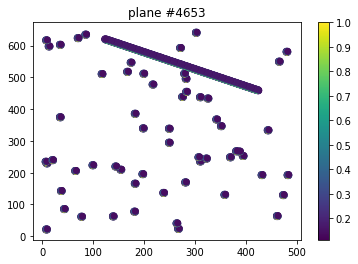

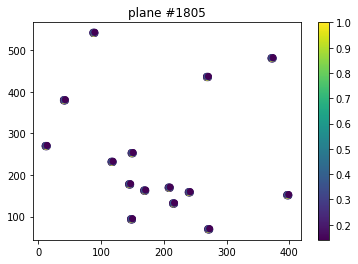

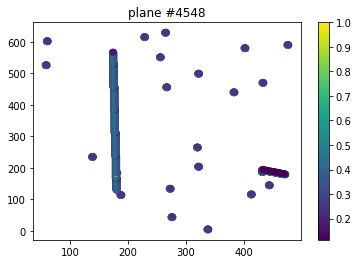

In [5]:
pg.visualize(3)

In [6]:
pg.cast_float16()
pg.write(record_dir)